In [1]:
%load_ext autoreload
%autoreload 2

import os
import math
import time
import json
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken
from typing import Optional

from context_compression.data import DataLoaderLite
from context_compression.model import GPT, GPTConfig
from context_compression.attn import AttentionKind, ProtectionKind, SelectionHeadLinearComboKind

device_id = -1
assert torch.cuda.is_available(), "come on man. we need cuda"
device = "cuda"

enc = tiktoken.get_encoding("gpt2")


In [2]:
class DataLoaderWrapper:
    def __init__(self, B, T, process_rank, num_processes, split, use_hf_style_inputs=False):
        self.loader = DataLoaderLite(B, T, process_rank, num_processes, split, use_hf_style_inputs)
        self.loader.reset()  # ensure the internal state is initialized

    def __iter__(self):
        return self

    def __next__(self):
        # next_batch is expected to return a batch (or, if desired, you could
        # add a stopping condition to eventually raise StopIteration).
        return self.loader.next_batch()

dataloader = DataLoaderWrapper(B=2, T=64, process_rank=0, num_processes=1, split="train",use_hf_style_inputs=True)

In [3]:
from mup.coord_check import get_coord_data,plot_coord_data
from mup import set_base_shapes

def lazy_model_inner(width):
    head_dim = 64
    seq_len = 64
    assert width % head_dim == 0, "width must be divisible by 64"
    config = GPTConfig(
        n_head=width // head_dim,
        head_dim=head_dim,
        n_embd=width,
        block_size=seq_len,
        n_layer=4,
        disable_selection=True,
        epsilon=0.0, # mup doesn't work with regularization
        use_hf_style_inputs=True,
        attention_kind=AttentionKind.SELECTIVE,
        for_inference=False,
        mup=True,
        query_zero_init=True,
        readout_zero_init=True,
    )
    return GPT(config).cuda()

base_model = lazy_model_inner(64)
delta_model = lazy_model_inner(128)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:02<00:00,  2.20it/s]
/opt/conda/lib/python3.11/site-packages/mup/coord_check.py:496: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


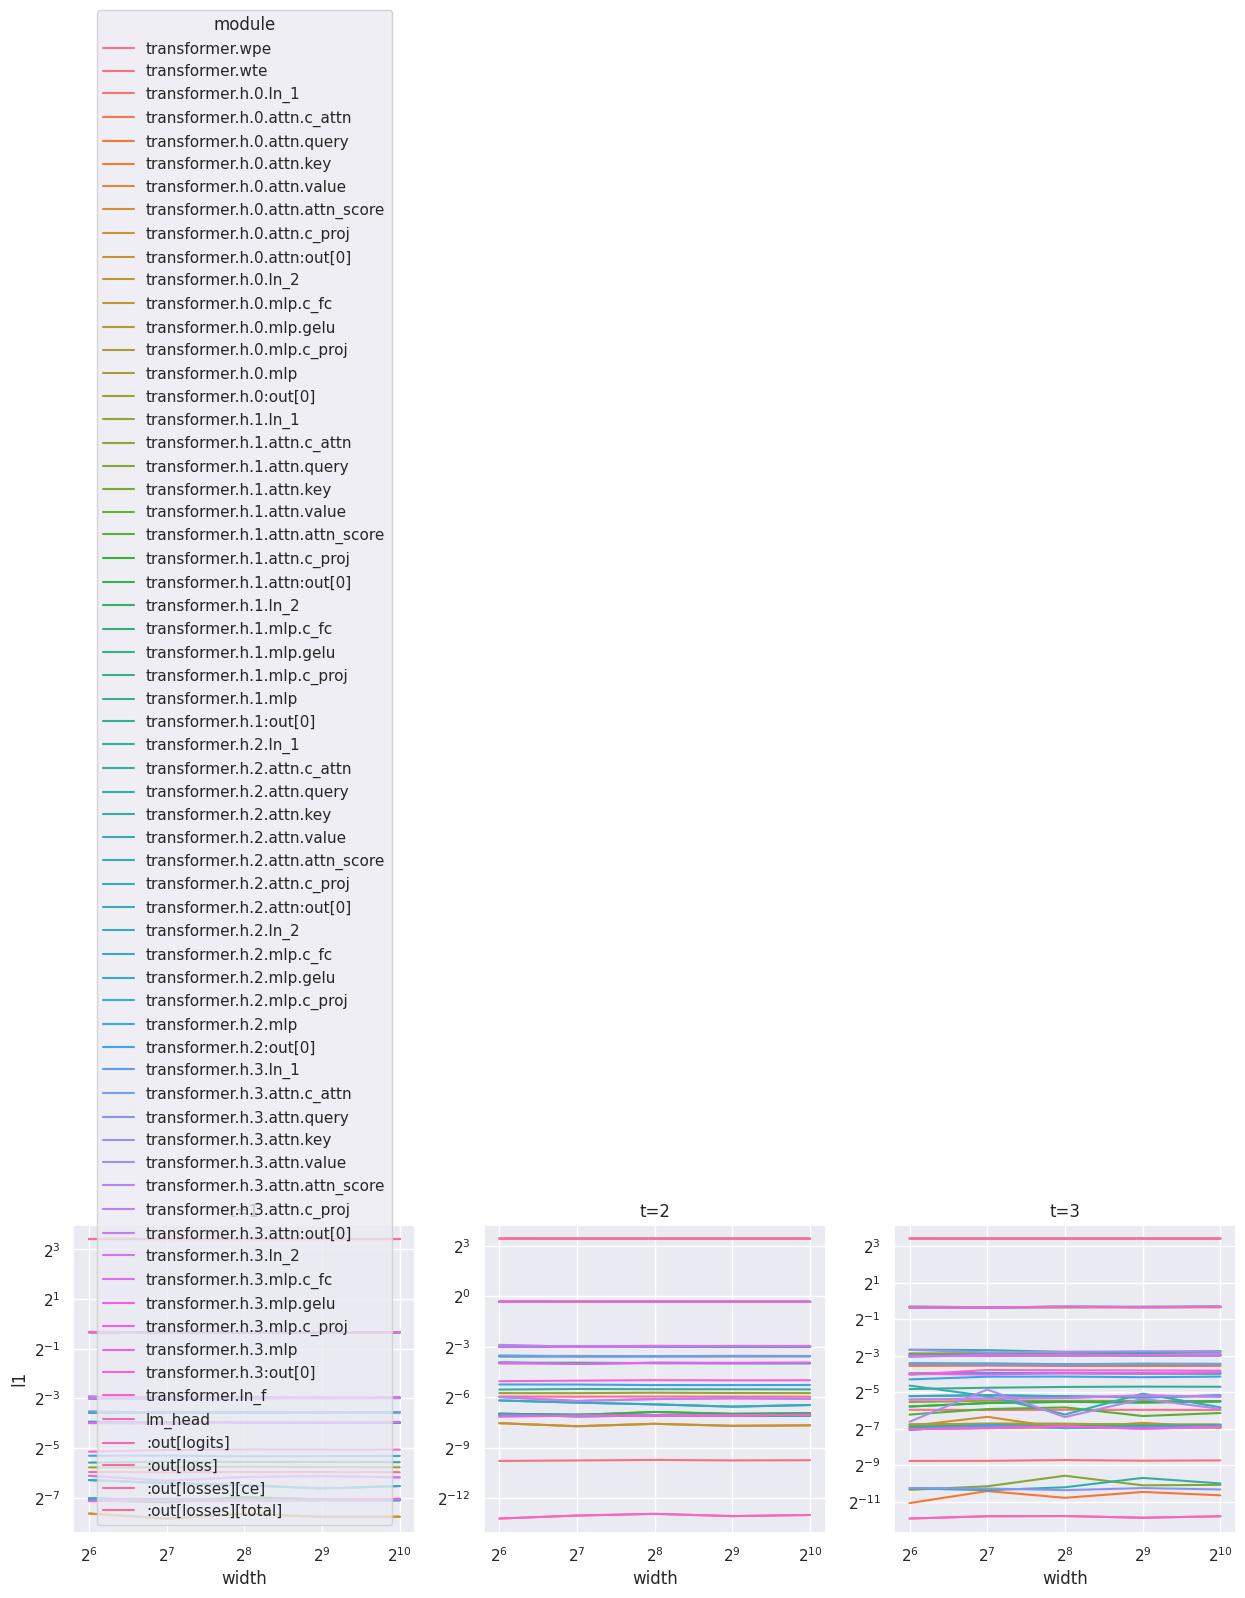

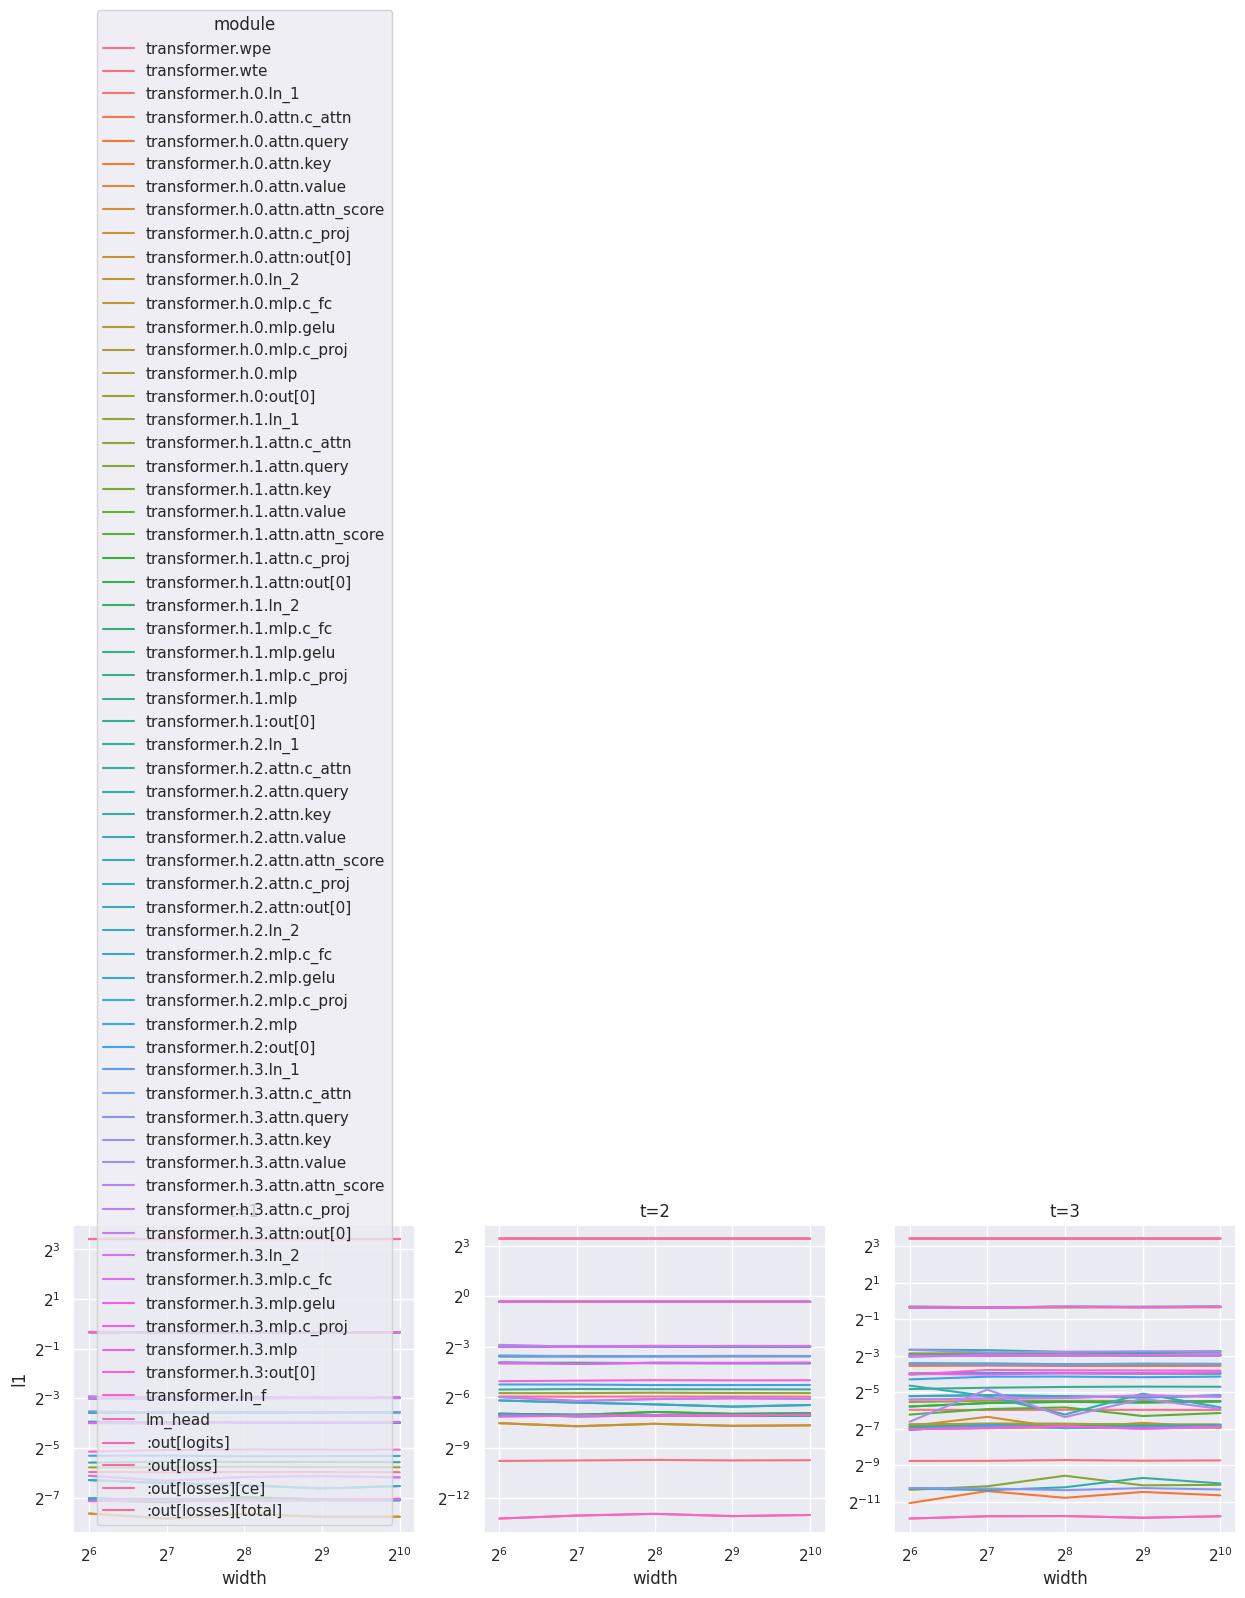

In [4]:
def lazy_model(width):
    def inner():
        model = set_base_shapes(lazy_model_inner(width),base_model,delta=delta_model,rescale_params=False)
        model.apply(model._init_weights)
        return model
    return inner

models = {64: lazy_model(64), 128: lazy_model(128), 256: lazy_model(256), 512: lazy_model(512), 1024: lazy_model(1024)}

df = get_coord_data(models,dataloader,dict_in_out=True,output_name="loss")

plot_coord_data(df)